In [1]:
import os
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

def initialize_firebase():
    """
    Initialize Firebase with fallback credential paths and return a Firestore client.
    """
    # Define your credential paths
    vm_path = r"C:\MasterThesis\Keys.json"
    primary_path = r"C:\Users\sajad\OneDrive\Skole\DevRepos\Master Thesis\Keys.json"
    fallback_path = r"C:\Users\Benja\OneDrive\Skole\DevRepos\Master Thesis\Keys.json"

    if not firebase_admin._apps:
        cred = None
        if os.path.exists(vm_path):
            cred = credentials.Certificate(vm_path)
        elif os.path.exists(primary_path):
            cred = credentials.Certificate(primary_path)
        elif os.path.exists(fallback_path):
            cred = credentials.Certificate(fallback_path)
        else:
            raise FileNotFoundError("Firebase credentials file not found in any of the specified paths.")
        
        firebase_admin.initialize_app(cred)

    return firestore.client()

db = initialize_firebase()

# 🧹 Extract Data from Firestore
def fetch_model_recommendations():
    try:
        collection_ref = db.collection("model_recommendations")
        docs = collection_ref.stream()
        
        data = []
        for doc in docs:
            doc_data = doc.to_dict()
            data.append(doc_data)
        
        # Convert to Pandas DataFrame
        df = pd.DataFrame(data)
        print("✅ Data fetched successfully!")
        return df
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        return pd.DataFrame()

# Fetch data
df = fetch_model_recommendations()

# Delete the "recommendation_detail" column if it exists
if "recommendation_detail" in df.columns:
    df.drop("recommendation_detail", axis=1, inplace=True)
    print("🗑️ 'recommendation_detail' column removed.")
else:
    print("ℹ️ 'recommendation_detail' column not found. No action taken.")

# Save the data to a CSV file for backup
df.to_csv("model_recommendations.csv", index=False)
print(df.head())
print("📁 Data saved to 'model_recommendations.csv' successfully!")

✅ Data fetched successfully!
🗑️ 'recommendation_detail' column removed.
  stock_ticker                                  sentiment_summary  \
0         NVDA  {'negative': 47.34950000000001, 'neutral': 45....   
1         MSFT  {'negative': 302.63780000000025, 'neutral': 29...   
2         AAPL  {'negative': 99.60730000000002, 'neutral': 112...   
3         NVDA  {'negative': 61.45169999999999, 'neutral': 56....   
4         AAPL  {'negative': 304.4951000000001, 'neutral': 309...   

   latest_close  previous_close is_correct gpt_recommendation  \
0    133.809799      129.839996       True                Buy   
1    389.845001      354.559998       True                Buy   
2           NaN             NaN      False                Buy   
3    131.139999      132.800003      False                Buy   
4    223.134995      222.130005      False               Sell   

  aggregator_recommendation                   timestamp  experiment_day  
0                       Buy  2025-02-10T21:57:30

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("model_recommendations.csv")

# Replace 'Hold' recommendations in GPT with Aggregator recommendations
df.loc[df['gpt_recommendation'].str.lower() == 'hold', 'gpt_recommendation'] = df['aggregator_recommendation']

# Save the updated dataset
df.to_csv("model_recommendations.csv", index=False)

print("✅ Replaced 'Hold' recommendations and updated the dataset.")



✅ Replaced 'Hold' recommendations and updated the dataset.


In [3]:
import pandas as pd

# 1. Load the raw CSV
df = pd.read_csv("model_recommendations.csv")  # or your chosen file

# 2. Parse the timestamp column into a datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 3. Extract just the date (YYYY-MM-DD) from the timestamp
df["date_only"] = df["timestamp"].dt.date

# 4. Identify duplicates using (stock_ticker + date_only), but do NOT drop them
initial_count = len(df)
df.sort_values(by=["stock_ticker", "date_only", "timestamp"], inplace=True)  # optional sort for consistent ordering
duplicate_mask = df.duplicated(subset=["stock_ticker", "date_only"], keep="first")
duplicate_count = duplicate_mask.sum()

print(f"Initial row count: {initial_count}")
print(f"Number of duplicates for the same ticker and date: {duplicate_count}")

# 5. Check for missing values
missing_values = df.isnull().sum()
total_missing = missing_values.sum()

print("\nMissing values per column:")
print(missing_values)
print(f"Total missing values: {total_missing}")

# 6. Output summary (no rows dropped)
if duplicate_count > 0:
    print(f"\n⚠️ There are {duplicate_count} duplicates that share the same ticker and date. No rows were dropped.")
else:
    print("\n✅ No duplicates detected for the same ticker and date.")

if total_missing == 0:
    print("✅ No missing values found. Dataset is fully intact!")
else:
    print(f"⚠️ Found {total_missing} missing entries. Consider imputing or removing them.")


Initial row count: 356
Number of duplicates for the same ticker and date: 55

Missing values per column:
stock_ticker                  0
sentiment_summary             0
latest_close                 21
previous_close               21
is_correct                    5
gpt_recommendation            0
aggregator_recommendation     0
timestamp                     0
experiment_day                0
date_only                     0
dtype: int64
Total missing values: 47

⚠️ There are 55 duplicates that share the same ticker and date. No rows were dropped.
⚠️ Found 47 missing entries. Consider imputing or removing them.


# Cleaning

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def clean_model_recommendations(file_path, output_path_v1, output_path_v2):
    # 1. Load dataset
    df = pd.read_csv(file_path)

    # 2. Convert timestamps to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # 3. Keep only the latest recommendation per stock per day
    df['date'] = df['timestamp'].dt.date
    df = df.sort_values(by='timestamp', ascending=False)
    df = df.drop_duplicates(subset=['stock_ticker', 'date'], keep='first')
    df = df.drop(columns=['date'])

    # 4. Remove rows with missing price data or missing 'is_correct'
    df_cleaned = df.dropna(subset=['latest_close', 'previous_close', 'is_correct'])

    # 5. Add price_direction column: 1 if price went up, -1 if down, 0 if flat
    df_cleaned['price_direction'] = df_cleaned.apply(
        lambda row: 1 if row['latest_close'] > row['previous_close'] 
                    else (-1 if row['latest_close'] < row['previous_close'] else 0),
        axis=1
    )

    # 6. Deduplicate news articles (if applicable)
    if 'news_title' in df_cleaned.columns and 'news_content' in df_cleaned.columns:
        df_cleaned = remove_duplicate_news(df_cleaned)

    # 7. Add is_correct2 column: checks if aggregator_recommendation matches price_direction
    def check_aggregator_correctness(row):
        mapping = {"Buy": 1, "Sell": -1, "Hold": 0}
        expected = mapping.get(row['aggregator_recommendation'], None)
        return expected == row['price_direction']

    df_cleaned['is_correct2'] = df_cleaned.apply(check_aggregator_correctness, axis=1)

    # 8. Save cleaned versions
    df_cleaned.to_csv(output_path_v1, index=False)
    df_cleaned.to_csv(output_path_v2, index=False)
    print(f"✅ Cleaned data saved to: {output_path_v1}")
    print(f"✅ Extended version with is_correct2 saved to: {output_path_v2}")

    return df_cleaned

# Example usage
file_path = "model_recommendations.csv"
output_path_v1 = "model_recommendations_cleaned.csv"
output_path_v2 = "model_recommendations_cleaned2.csv"

df_cleaned = clean_model_recommendations(file_path, output_path_v1, output_path_v2)


✅ Cleaned data saved to: model_recommendations_cleaned.csv
✅ Extended version with is_correct2 saved to: model_recommendations_cleaned2.csv


C:\Users\sajad\AppData\Local\Temp\ipykernel_6924\2054329065.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['price_direction'] = df_cleaned.apply(
C:\Users\sajad\AppData\Local\Temp\ipykernel_6924\2054329065.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['is_correct2'] = df_cleaned.apply(check_aggregator_correctness, axis=1)


In [5]:
df_before = pd.read_csv("model_recommendations.csv")
df_after = pd.read_csv("model_recommendations_cleaned.csv")

print("Before Cleaning:")
print(df_before['is_correct'].value_counts())

print("\nAfter Cleaning:")
print(df_after['is_correct'].value_counts())

# print the shape of both dataframes
print(f"\nShape of original data: {df_before.shape}")
print(f"Shape of cleaned data: {df_after.shape}")

Before Cleaning:
is_correct
False    190
True     161
Name: count, dtype: int64

After Cleaning:
is_correct
False    148
True     143
Name: count, dtype: int64

Shape of original data: (356, 9)
Shape of cleaned data: (291, 11)


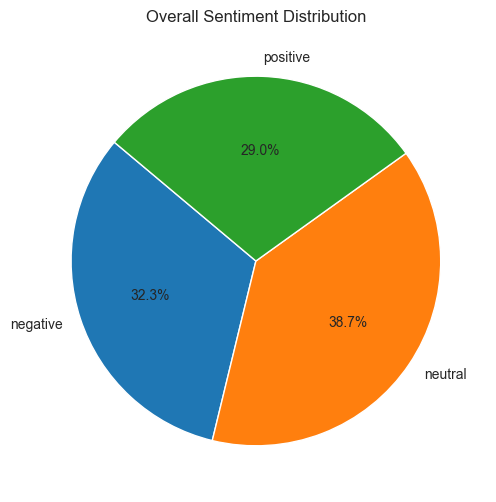

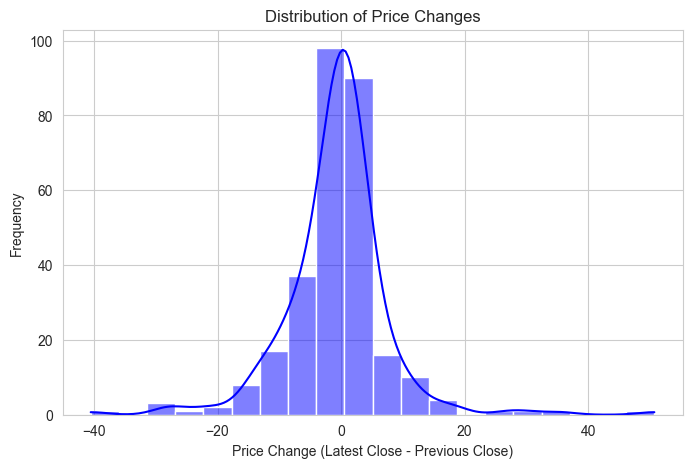

C:\Users\sajad\AppData\Local\Temp\ipykernel_6924\218667454.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=direction_counts.index, y=direction_counts.values, palette="viridis")


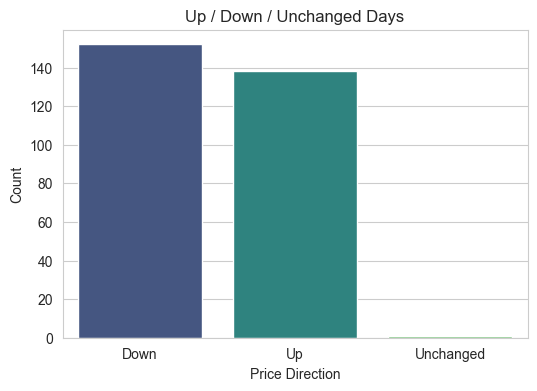

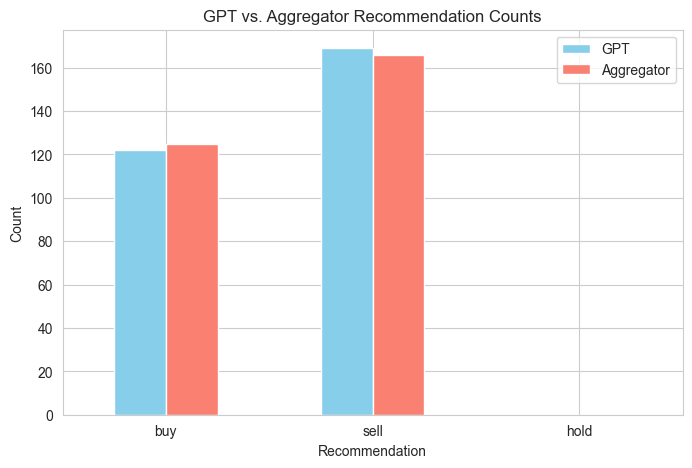

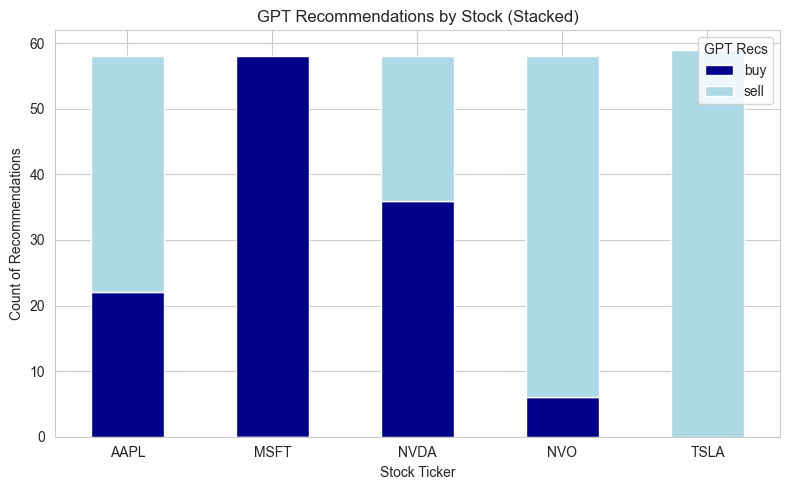

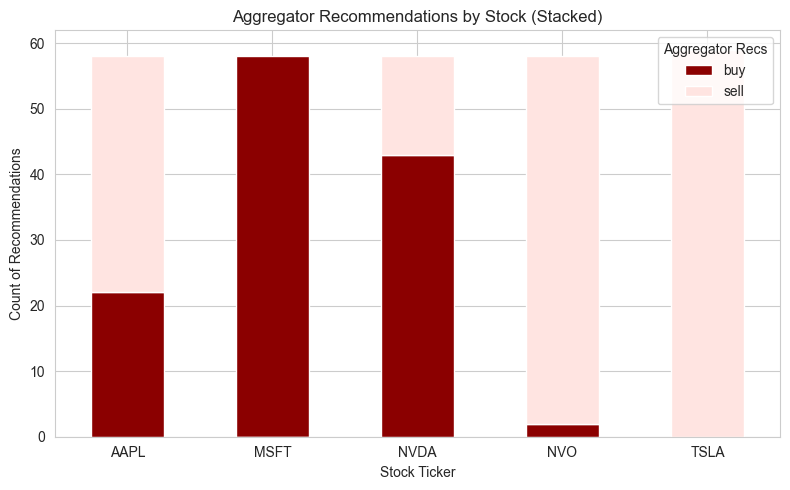

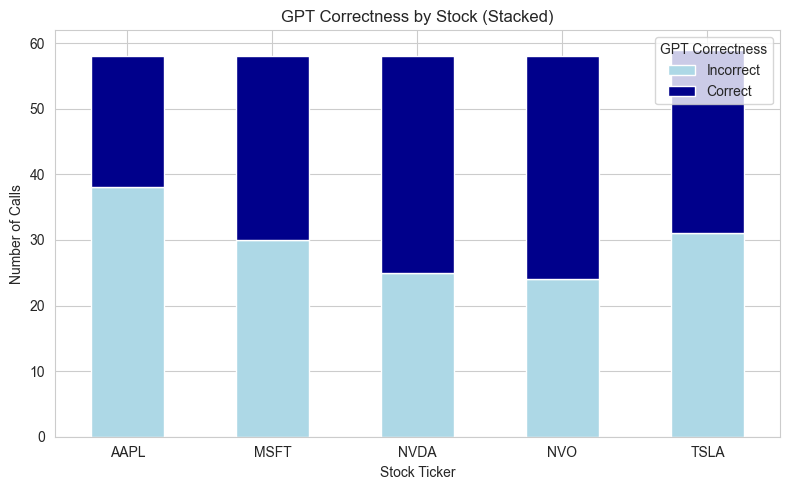

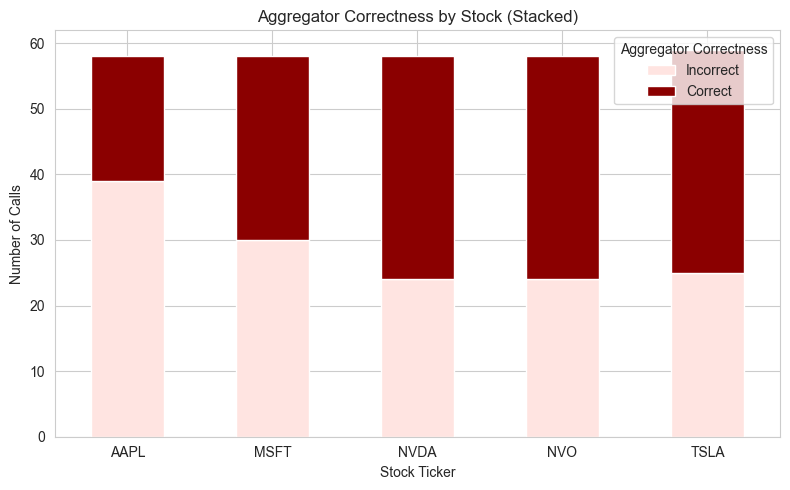

C:\Users\sajad\AppData\Local\Temp\ipykernel_6924\218667454.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=["skyblue", "salmon"])


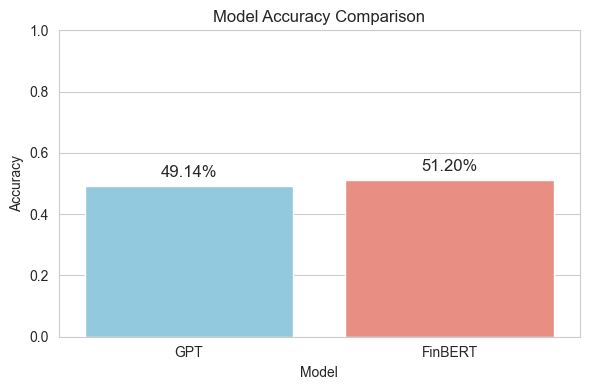

=== Accuracy Summary ===
GPT Accuracy: 49.14% (143 correct out of 291)
Aggregator Accuracy: 51.20% (149 correct out of 291)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- 0. LOAD & PREPARE DATA -------------
cleaned_file_path = "model_recommendations_cleaned2.csv"
df_cleaned = pd.read_csv(cleaned_file_path)

# Convert 'timestamp' to datetime
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# If 'sentiment_summary' is a string representation of a dict, parse it
if 'sentiment_summary' in df_cleaned.columns:
    df_cleaned['sentiment_dict'] = df_cleaned['sentiment_summary'].apply(eval)

# Normalize recommendation columns
df_cleaned['gpt_recommendation'] = df_cleaned['gpt_recommendation'].str.lower()
df_cleaned['aggregator_recommendation'] = df_cleaned['aggregator_recommendation'].str.lower()

# Setup plotting style
sns.set_style("whitegrid")
plt.rcParams.update({'figure.figsize': (8, 5)})

# ---------------------- PLOTTING FUNCTIONS ----------------------

def plot_sentiment_distribution(df):
    sentiment_df = pd.json_normalize(df['sentiment_dict'])
    if sentiment_df.empty:
        print("No sentiment_dict found or it's empty.")
        return

    sentiment_sums = sentiment_df.sum(numeric_only=True)
    plt.figure(figsize=(6, 6))
    sentiment_sums.plot(kind='pie', autopct='%1.1f%%', startangle=140, label='')
    plt.title("Overall Sentiment Distribution")
    plt.ylabel("")
    plt.show()

def plot_distribution_of_price_changes(df):
    df['price_change'] = df['latest_close'] - df['previous_close']
    plt.figure(figsize=(8,5))
    sns.histplot(df['price_change'], bins=20, kde=True, color="blue")
    plt.title("Distribution of Price Changes")
    plt.xlabel("Price Change (Latest Close - Previous Close)")
    plt.ylabel("Frequency")
    plt.show()

def plot_up_down_unchanged(df):
    if 'price_direction' not in df.columns:
        print("No 'price_direction' column found.")
        return
    direction_counts = df['price_direction'].value_counts()
    direction_label_map = {1: 'Up', -1: 'Down', 0: 'Unchanged'}
    direction_counts.index = direction_counts.index.map(direction_label_map)
    plt.figure(figsize=(6,4))
    sns.barplot(x=direction_counts.index, y=direction_counts.values, palette="viridis")
    plt.title("Up / Down / Unchanged Days")
    plt.xlabel("Price Direction")
    plt.ylabel("Count")
    plt.show()

def plot_gpt_vs_aggregator_counts(df):
    gpt_counts = df['gpt_recommendation'].value_counts()
    agg_counts = df['aggregator_recommendation'].value_counts()
    combined_df = pd.DataFrame({'GPT': gpt_counts, 'Aggregator': agg_counts}).fillna(0)
    combined_df = combined_df.reindex(['buy','sell','hold']).fillna(0)
    combined_df.plot(kind='bar', rot=0, color=['skyblue','salmon'])
    plt.title("GPT vs. Aggregator Recommendation Counts")
    plt.xlabel("Recommendation")
    plt.ylabel("Count")
    plt.legend(loc='best')
    plt.show()

def plot_recommendations_by_stock(df):
    # GPT Recommendation Counts by Stock
    gpt_recs = df.groupby(['stock_ticker', 'gpt_recommendation']).size().unstack(fill_value=0)
    gpt_recs = gpt_recs[['buy', 'sell']] if set(['buy', 'sell']).issubset(gpt_recs.columns) else gpt_recs
    gpt_recs.plot(kind='bar', stacked=True, figsize=(8,5), color=['darkblue', 'lightblue'])
    plt.title("GPT Recommendations by Stock (Stacked)")
    plt.xlabel("Stock Ticker")
    plt.ylabel("Count of Recommendations")
    plt.legend(title="GPT Recs")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Aggregator Recommendation Counts by Stock
    agg_recs = df.groupby(['stock_ticker', 'aggregator_recommendation']).size().unstack(fill_value=0)
    agg_recs = agg_recs[['buy', 'sell']] if set(['buy', 'sell']).issubset(agg_recs.columns) else agg_recs
    agg_recs.plot(kind='bar', stacked=True, figsize=(8,5), color=['darkred', 'mistyrose'])
    plt.title("Aggregator Recommendations by Stock (Stacked)")
    plt.xlabel("Stock Ticker")
    plt.ylabel("Count of Recommendations")
    plt.legend(title="Aggregator Recs")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_correctness_by_stock(df):
    if 'is_correct' in df.columns:
        gpt_correctness = df.groupby(["stock_ticker", "is_correct"])["is_correct"].count().unstack(fill_value=0)
        gpt_correctness.columns = ["Incorrect", "Correct"]
        plt.figure(figsize=(8, 5))
        gpt_correctness.plot(kind='bar', stacked=True, ax=plt.gca(), color=['lightblue','darkblue'])
        plt.title("GPT Correctness by Stock (Stacked)")
        plt.xlabel("Stock Ticker")
        plt.ylabel("Number of Calls")
        plt.legend(title="GPT Correctness")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

    if 'is_correct2' in df.columns:
        agg_correctness = df.groupby(["stock_ticker", "is_correct2"])["is_correct2"].count().unstack(fill_value=0)
        agg_correctness.columns = ["Incorrect", "Correct"]
        plt.figure(figsize=(8, 5))
        agg_correctness.plot(kind='bar', stacked=True, ax=plt.gca(), color=['mistyrose','darkred'])
        plt.title("Aggregator Correctness by Stock (Stacked)")
        plt.xlabel("Stock Ticker")
        plt.ylabel("Number of Calls")
        plt.legend(title="Aggregator Correctness")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

def plot_model_accuracy_comparison(df):
    accuracies = {}
    if 'is_correct' in df.columns:
        accuracies['GPT'] = df['is_correct'].mean()
    if 'is_correct2' in df.columns:
        accuracies['FinBERT'] = df['is_correct2'].mean()
    if not accuracies:
        print("No accuracy columns found in DataFrame.")
        return
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=["skyblue", "salmon"])
    plt.ylim(0, 1)
    for i, acc in enumerate(accuracies.values()):
        plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', va='bottom', fontsize=12)
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()

    # --------------------- Accuracy Metrics ---------------------
    print("=== Accuracy Summary ===")
    if 'is_correct' in df_cleaned.columns:
        gpt_accuracy = df_cleaned['is_correct'].mean()
        print(f"GPT Accuracy: {gpt_accuracy:.2%} ({df_cleaned['is_correct'].sum()} correct out of {len(df_cleaned)})")

    if 'is_correct2' in df_cleaned.columns:
        aggregator_accuracy = df_cleaned['is_correct2'].mean()
        print(f"Aggregator Accuracy: {aggregator_accuracy:.2%} ({df_cleaned['is_correct2'].sum()} correct out of {len(df_cleaned)})")

# ---------------------- EXECUTE PLOTS ----------------------

plot_sentiment_distribution(df_cleaned)
plot_distribution_of_price_changes(df_cleaned)
plot_up_down_unchanged(df_cleaned)
plot_gpt_vs_aggregator_counts(df_cleaned)
plot_recommendations_by_stock(df_cleaned)  # <-- NEW FUNCTION
plot_correctness_by_stock(df_cleaned)
plot_model_accuracy_comparison(df_cleaned)


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import binomtest, norm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

def map_recommendation(rec):
    if isinstance(rec, str):
        rec_lower = rec.lower()
        if 'buy' in rec_lower:
            return 1
        elif 'sell' in rec_lower:
            return -1
        elif 'hold' in rec_lower:
            return 0
    return 0

def run_statistical_tests(df, recommendation_col, correctness_col):
    df = df.copy()
    df['recommendation_numeric'] = df[recommendation_col].apply(map_recommendation)
    df['is_correct'] = df[correctness_col]

    total_predictions = len(df)
    correct_predictions = df['is_correct'].sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0

    baseline_prob = 0.5
    p_binomial = binomtest(correct_predictions,
                           total_predictions,
                           p=baseline_prob,
                           alternative='greater').pvalue

    std_error = (np.sqrt((accuracy * (1 - accuracy)) / total_predictions)
                 if total_predictions > 0 else 0)
    z_score = norm.ppf(0.975)
    lower_bound = accuracy - z_score * std_error
    upper_bound = accuracy + z_score * std_error

    z_value = (accuracy - baseline_prob) / (std_error if std_error != 0 else 1)
    p_ztest = 2 * (1 - norm.cdf(abs(z_value)))

    return {
        "accuracy": accuracy,
        "confidence_interval": (lower_bound, upper_bound),
        "binomial_p_value": p_binomial,
        "z_test_p_value": p_ztest,
        "total_predictions": total_predictions,
        "correct_predictions": correct_predictions
    }

def compute_precision_recall(df, recommendation_col):
    df_filtered = df[df[recommendation_col].str.lower().isin(['buy', 'sell'])]
    if df_filtered.empty:
        return {k: 0 for k in [
            "precision_buy", "recall_buy", "f1_buy",
            "precision_sell", "recall_sell", "f1_sell"
        ]}

    y_true = df_filtered['price_direction'].apply(lambda x: 1 if x == 1 else -1)
    y_pred = df_filtered[recommendation_col].apply(map_recommendation)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred,
        labels=[1, -1],
        zero_division=0
    )

    return {
        "precision_buy":  precision[0],
        "recall_buy":     recall[0],
        "f1_buy":         f1[0],
        "precision_sell": precision[1],
        "recall_sell":    recall[1],
        "f1_sell":        f1[1],
    }

def compute_confusion_matrix(df, recommendation_col):
    df_filtered = df[df[recommendation_col].str.lower().isin(['buy', 'sell'])]
    if df_filtered.empty:
        return np.zeros((2,2), dtype=int)
    y_true = df_filtered['price_direction'].apply(lambda x: 1 if x == 1 else -1)
    y_pred = df_filtered[recommendation_col].apply(map_recommendation)
    return confusion_matrix(y_true, y_pred, labels=[1, -1])

def count_recommendation_types(df, recommendation_col):
    counts = df[recommendation_col].str.lower().value_counts()
    return {
        "buy_count":  counts.get('buy',  0),
        "sell_count": counts.get('sell', 0),
        "hold_count": counts.get('hold', 0)
    }

# Load dataset
df = pd.read_csv("model_recommendations_cleaned2.csv")
df['is_correct']  = df['is_correct'].astype(bool)
df['is_correct2'] = df['is_correct2'].astype(bool)

# --- Add random (coin-flip) baseline ---
np.random.seed(42)
df['random_recommendation'] = np.random.choice(['buy', 'sell'], size=len(df))
df['is_correct_random'] = (
    df['random_recommendation'].apply(map_recommendation)
    == df['price_direction']
)

# 1. Statistical tests
gpt_results        = run_statistical_tests(df, "gpt_recommendation",        "is_correct")
aggregator_results = run_statistical_tests(df, "aggregator_recommendation", "is_correct2")
random_results     = run_statistical_tests(df, "random_recommendation",     "is_correct_random")

# 2. Precision/Recall
gpt_metrics        = compute_precision_recall(df, "gpt_recommendation")
aggregator_metrics = compute_precision_recall(df, "aggregator_recommendation")
random_metrics     = compute_precision_recall(df, "random_recommendation")

# 3. Recommendation counts
gpt_counts        = count_recommendation_types(df, "gpt_recommendation")
aggregator_counts = count_recommendation_types(df, "aggregator_recommendation")
random_counts     = count_recommendation_types(df, "random_recommendation")

# 4. Confusion matrices
gpt_conf_matrix        = compute_confusion_matrix(df, "gpt_recommendation")
aggregator_conf_matrix = compute_confusion_matrix(df, "aggregator_recommendation")
random_conf_matrix     = compute_confusion_matrix(df, "random_recommendation")

# 5. Output summary
print("\nPerformance Summary (with 95% CI)")
print(f"GPT Accuracy:        {gpt_results['accuracy']:.2%} "
      f"({gpt_results['confidence_interval'][0]:.2%}–{gpt_results['confidence_interval'][1]:.2%})  "
      f"| Aggregator: {aggregator_results['accuracy']:.2%} "
      f"({aggregator_results['confidence_interval'][0]:.2%}–{aggregator_results['confidence_interval'][1]:.2%})  "
      f"| Random:     {random_results['accuracy']:.2%} "
      f"({random_results['confidence_interval'][0]:.2%}–{random_results['confidence_interval'][1]:.2%})\n")

print("Binomial p-values (B)  |  Z-test p-values (Z)")
print(f" GPT:        B={gpt_results['binomial_p_value']:.4f}  Z={gpt_results['z_test_p_value']:.4f}")
print(f" Aggregator: B={aggregator_results['binomial_p_value']:.4f}  Z={aggregator_results['z_test_p_value']:.4f}")
print(f" Random:     B={random_results['binomial_p_value']:.4f}  Z={random_results['z_test_p_value']:.4f}\n")

print("Recommendation Counts")
print(f" GPT - Buy: {gpt_counts['buy_count']}, Sell: {gpt_counts['sell_count']}, Hold: {gpt_counts['hold_count']}")
print(f" Agg - Buy: {aggregator_counts['buy_count']}, Sell: {aggregator_counts['sell_count']}, Hold: {aggregator_counts['hold_count']}")
print(f" Rand- Buy: {random_counts['buy_count']}, Sell: {random_counts['sell_count']}, Hold: {random_counts['hold_count']}\n")

print("Precision, Recall & F1 (Buy / Sell)")
for name, m in [("GPT", gpt_metrics),
                ("Aggregator", aggregator_metrics),
                ("Random", random_metrics)]:
    print(f"{name:10s}→ Buy:  P {m['precision_buy']:.2%}  R {m['recall_buy']:.2%}  F1 {m['f1_buy']:.2%}  |  "
          f"Sell: P {m['precision_sell']:.2%}  R {m['recall_sell']:.2%}  F1 {m['f1_sell']:.2%}")

print("\nConfusion Matrices (rows=true [Buy, Sell], cols=predicted [Buy, Sell])")
print("GPT:\n",        gpt_conf_matrix)
print("Aggregator:\n", aggregator_conf_matrix)
print("Random:\n",     random_conf_matrix)



Performance Summary (with 95% CI)
GPT Accuracy:        49.14% (43.40%–54.88%)  | Aggregator: 51.20% (45.46%–56.95%)  | Random:     50.17% (44.43%–55.92%)

Binomial p-values (B)  |  Z-test p-values (Z)
 GPT:        B=0.6374  Z=0.7694
 Aggregator: B=0.3626  Z=0.6815
 Random:     B=0.5000  Z=0.9533

Recommendation Counts
 GPT - Buy: 122, Sell: 169, Hold: 0
 Agg - Buy: 125, Sell: 166, Hold: 0
 Rand- Buy: 147, Sell: 144, Hold: 0

Precision, Recall & F1 (Buy / Sell)
GPT       → Buy:  P 48.36%  R 42.75%  F1 45.38%  |  Sell: P 53.25%  R 58.82%  F1 55.90%
Aggregator→ Buy:  P 48.80%  R 44.20%  F1 46.39%  |  Sell: P 53.61%  R 58.17%  F1 55.80%
Random    → Buy:  P 47.62%  R 50.72%  F1 49.12%  |  Sell: P 52.78%  R 49.67%  F1 51.18%

Confusion Matrices (rows=true [Buy, Sell], cols=predicted [Buy, Sell])
GPT:
 [[59 79]
 [63 90]]
Aggregator:
 [[61 77]
 [64 89]]
Random:
 [[70 68]
 [77 76]]


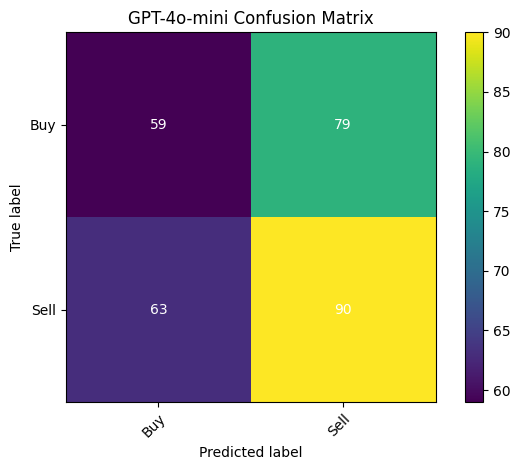

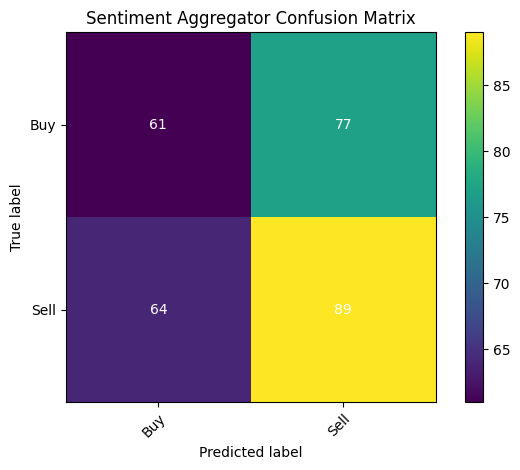

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define confusion matrices
gpt_cm = np.array([[59, 79],
                   [63, 90]])
agg_cm = np.array([[61, 77],
                   [64, 89]])

# Function to plot a confusion matrix
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=['Buy', 'Sell'],
        yticklabels=['Buy', 'Sell'],
        ylabel='True label',
        xlabel='Predicted label',
        title=title
    )
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Plot GPT confusion matrix
plot_confusion_matrix(gpt_cm, "GPT-4o-mini Confusion Matrix")

# Plot Aggregator confusion matrix
plot_confusion_matrix(agg_cm, "Sentiment Aggregator Confusion Matrix")


| Strategy    |   Cum % |   Cum $ (@ $100/Buy) |
|:------------|--------:|---------------------:|
| GPT-4o-mini |   -5.36 |                -5.36 |
| FinBERT     |   -8.36 |                -8.36 |
| Random      |  -49.98 |               -49.98 |


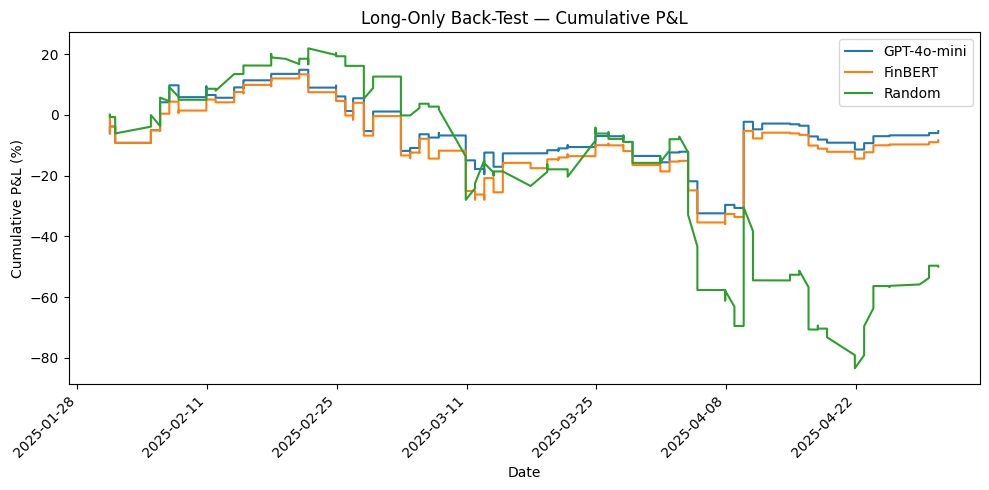

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 0. Load data
df = pd.read_csv("model_recommendations_cleaned2.csv", parse_dates=['timestamp'])

# 1. Daily return in percent
df['daily_return'] = (df['latest_close'] - df['previous_close']) / df['previous_close']

# 2. Map signals (Buy=1, Sell=0) and compute P&L
for model in [('gpt', 'gpt_recommendation'),
              ('agg', 'aggregator_recommendation'),
              ('rand', None)]:

    name, col = model
    if col:                              # GPT / FinBERT signals
        df[f'{name}_signal'] = df[col].map({'Buy': 1, 'Sell': 0})
    else:                                # random baseline
        np.random.seed(42)
        df['rand_signal'] = np.random.choice([0, 1], size=len(df))

# P&L as percent
df['gpt_pnl_pct']  = df['gpt_signal']  * df['daily_return']
df['agg_pnl_pct']  = df['agg_signal']  * df['daily_return']
df['rand_pnl_pct'] = df['rand_signal'] * df['daily_return']

# P&L in dollars (stake = 100 USD per Buy day)
stake = 100
df['gpt_pnl_$']  = df['gpt_pnl_pct']  * stake
df['agg_pnl_$']  = df['agg_pnl_pct']  * stake
df['rand_pnl_$'] = df['rand_pnl_pct'] * stake

# 3. Final cumulative P&L
cum_results = {
    'Strategy': ['GPT-4o-mini', 'FinBERT', 'Random'],
    'Cum %': [
        round(df['gpt_pnl_pct'].cumsum().iloc[-1]  * 100, 2),
        round(df['agg_pnl_pct'].cumsum().iloc[-1]  * 100, 2),
        round(df['rand_pnl_pct'].cumsum().iloc[-1] * 100, 2)
    ],
    'Cum $ (@ $100/Buy)': [
        round(df['gpt_pnl_$'].sum(), 2),
        round(df['agg_pnl_$'].sum(), 2),
        round(df['rand_pnl_$'].sum(), 2)
    ]
}
cum_df = pd.DataFrame(cum_results)
print(cum_df.to_markdown(index=False))

# 4. Plot cumulative % curves
df_sorted = df.sort_values('timestamp')
df_sorted['gpt_cum_pct']  = df_sorted['gpt_pnl_pct'].cumsum()  * 100
df_sorted['agg_cum_pct']  = df_sorted['agg_pnl_pct'].cumsum()  * 100
df_sorted['rand_cum_pct'] = df_sorted['rand_pnl_pct'].cumsum() * 100

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_sorted['timestamp'], df_sorted['gpt_cum_pct'],  label='GPT-4o-mini')
ax.plot(df_sorted['timestamp'], df_sorted['agg_cum_pct'],  label='FinBERT')
ax.plot(df_sorted['timestamp'], df_sorted['rand_cum_pct'], label='Random')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative P&L (%)')
ax.set_title('Long-Only Back-Test — Cumulative P&L')
ax.legend()
plt.tight_layout()
plt.show()


     Cum $  Cum % (vs start)  vs Buy&Hold (%)
gpt -40.78             -8.16             6.55
agg -32.38             -6.48             8.23
rnd -32.98             -6.60             8.11
bh  -73.55            -14.71             0.00


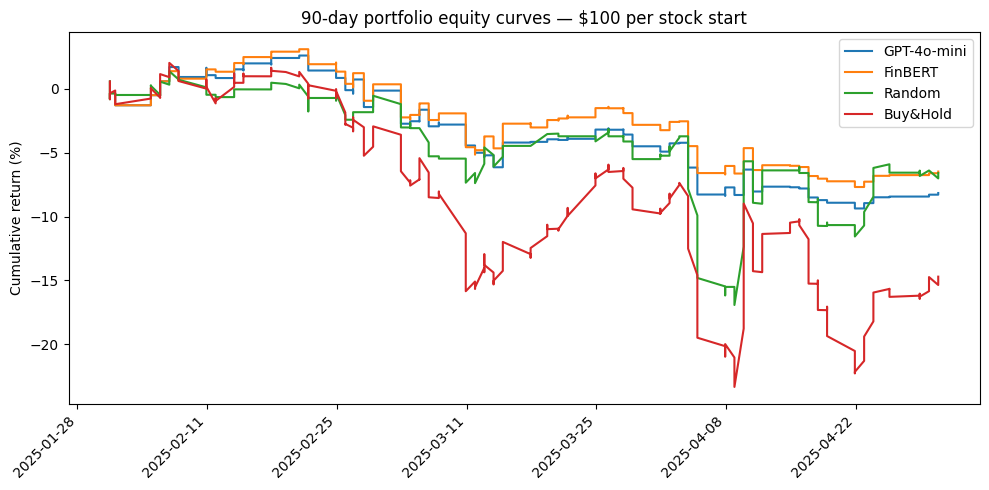

In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.dates as mdates

# ------------------------------------------------------------------
# 0.  Load data  (rename columns here if needed)
# ------------------------------------------------------------------
df = pd.read_csv("model_recommendations_cleaned2.csv", parse_dates=['timestamp'])

TICKER = 'stock_ticker'          # <- adjust to your exact header
SIGCOLS = {'gpt':'gpt_recommendation',
           'agg':'aggregator_recommendation'}

# ------------------------------------------------------------------
# 1.  Daily % return of each stock
# ------------------------------------------------------------------
df['ret_pct'] = (df['latest_close'] - df['previous_close']) / df['previous_close']

# ------------------------------------------------------------------
# 2.  Map Buy / Sell to 1 / 0   +  coin-flip baseline
# ------------------------------------------------------------------
for tag, col in SIGCOLS.items():
    df[f'{tag}_sig'] = df[col].map({'Buy':1, 'Sell':0})

np.random.seed(42)
df['rnd_sig'] = np.random.randint(0, 2, len(df))

# ------------------------------------------------------------------
# 3.  Build *positions*  (use previous-day signal; start fully invested)
# ------------------------------------------------------------------
df = df.sort_values([TICKER, 'timestamp'])
for tag in ['gpt', 'agg', 'rnd']:
    df[f'{tag}_pos'] = df.groupby(TICKER)[f'{tag}_sig'].shift(fill_value=1)

# ------------------------------------------------------------------
# 4.  Per-day P&L in dollars ( stake = $100 when in-market )
# ------------------------------------------------------------------
STAKE = 100
for tag in ['gpt', 'agg', 'rnd']:
    df[f'{tag}_pnl'] = df[f'{tag}_pos'] * STAKE * df['ret_pct']

# ------------------------------------------------------------------
# 5.  Buy-and-hold benchmark  — $100 per stock for full 90 days
# ------------------------------------------------------------------
df['bh_pnl'] = STAKE * df['ret_pct']          # always invested (= position 1)

# ------------------------------------------------------------------
# 6.  Aggregate to portfolio level (sum across tickers each day)
# ------------------------------------------------------------------
daily = (df.groupby('timestamp')[[f'{t}_pnl' for t in ['gpt','agg','rnd','bh']]]
         .sum()
         .cumsum())                           # equity curve in $

START_CAP = STAKE * df[TICKER].nunique()      # $100 per stock at t0

perf = (daily.iloc[-1]                       # ending equity minus start
        .rename(lambda s: s.replace('_pnl',''))
        .to_frame('Cum $')
        .assign(**{'Cum % (vs start)': lambda t: (t['Cum $']/START_CAP*100).round(2)}))

# ------------------------------------------------------------------
# 7.  Gap vs buy-and-hold
# ------------------------------------------------------------------
perf['vs Buy&Hold (%)'] = (perf['Cum % (vs start)'] -
                           perf.loc['bh','Cum % (vs start)']).round(2)

print(perf.round(2))

# ------------------------------------------------------------------
# 8.  Plot equity curves (%)
# ------------------------------------------------------------------
curve_pct = daily.div(START_CAP).mul(100)
fig, ax = plt.subplots(figsize=(10,5))
for col, lab in [('gpt_pnl','GPT-4o-mini'),
                 ('agg_pnl','FinBERT'),
                 ('rnd_pnl','Random'),
                 ('bh_pnl','Buy&Hold')]:
    ax.plot(curve_pct.index, curve_pct[col], label=lab)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Cumulative return (%)')
ax.set_title('90-day portfolio equity curves — $100 per stock start')
ax.legend(); plt.tight_layout(); plt.show()


Per‑Stock Long‑Only Back-Test (% and $):
Stock  GPT‑%  GPT $  FinBERT %  FinBERT $
 AAPL -13.03 -13.03     -13.03     -13.03
 MSFT -12.08 -12.08     -12.08     -12.08
 NVDA  17.73  17.73      16.23      16.23
  NVO   2.02   2.02       0.52       0.52
 TSLA   0.00   0.00       0.00       0.00


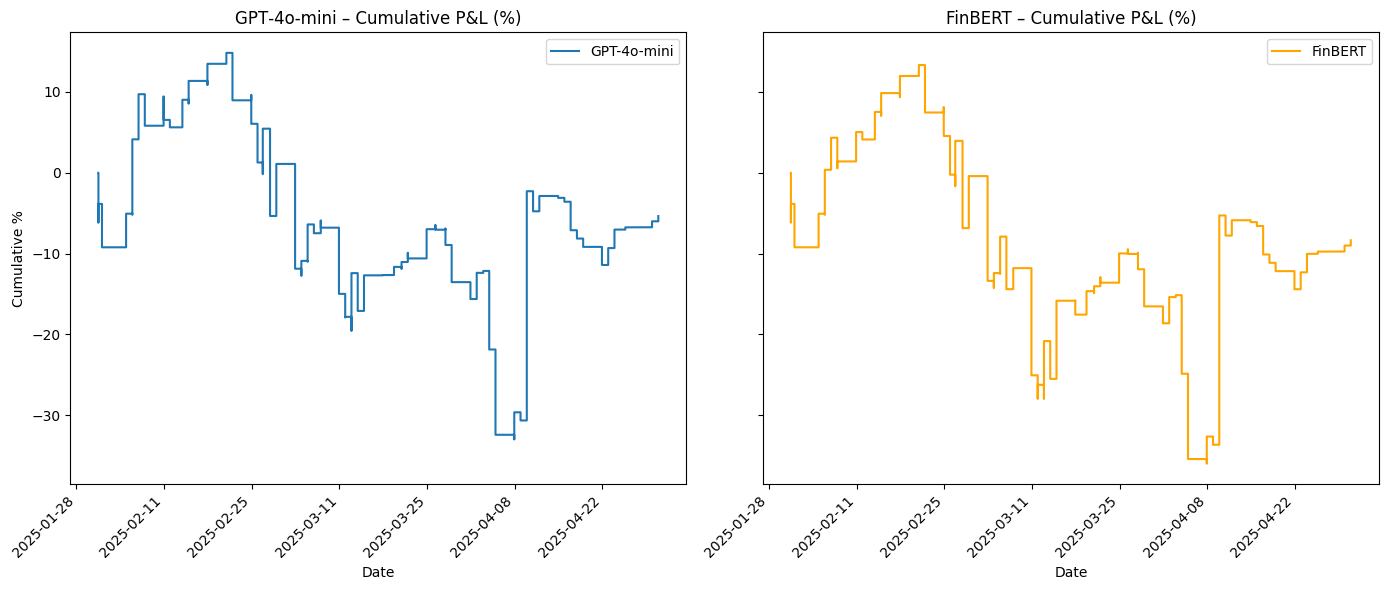

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 0. Load your cleaned CSV (update path/filename as needed)
df = pd.read_csv("model_recommendations_cleaned2.csv", parse_dates=['timestamp'])

# 1. Compute daily return (percentage)
df['daily_return'] = (df['latest_close'] - df['previous_close']) / df['previous_close']

# 2. Map signals to long‑only (Buy = 1, Sell = 0)
df['gpt_signal'] = df['gpt_recommendation'].map({'Buy': 1, 'Sell': 0})
df['agg_signal'] = df['aggregator_recommendation'].map({'Buy': 1, 'Sell': 0})

# 3. P&L in percent and dollars (stake = $100 for each Buy)
stake = 100
df['gpt_pnl_pct'] = df['gpt_signal'] * df['daily_return']
df['agg_pnl_pct'] = df['agg_signal'] * df['daily_return']
df['gpt_pnl_$']   = df['gpt_pnl_pct'] * stake
df['agg_pnl_$']   = df['agg_pnl_pct'] * stake

# 4. Per‑stock cumulative results
summary = []
for ticker, sub in df.groupby('stock_ticker'):
    sub = sub.sort_values('timestamp')
    gpt_pct = sub['gpt_pnl_pct'].cumsum().iloc[-1] * 100
    agg_pct = sub['agg_pnl_pct'].cumsum().iloc[-1] * 100
    gpt_dol = sub['gpt_pnl_$'].sum()
    agg_dol = sub['agg_pnl_$'].sum()
    summary.append({
        'Stock': ticker,
        'GPT‑%': round(gpt_pct, 2),
        'GPT $': round(gpt_dol, 2),
        'FinBERT %': round(agg_pct, 2),
        'FinBERT $': round(agg_dol, 2)
    })
results_df = pd.DataFrame(summary).sort_values('Stock')

# 5. Print formatted table
print("Per‑Stock Long‑Only Back-Test (% and $):")
print(results_df.to_string(index=False))

# 6. Plot cumulative % curves for both models
df_sorted = df.sort_values('timestamp')
df_sorted['gpt_cum_pct'] = df_sorted['gpt_pnl_pct'].cumsum() * 100
df_sorted['agg_cum_pct'] = df_sorted['agg_pnl_pct'].cumsum() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# GPT plot
axes[0].plot(df_sorted['timestamp'], df_sorted['gpt_cum_pct'], label='GPT-4o-mini')
axes[0].set_title('GPT‑4o‑mini – Cumulative P&L (%)')
axes[0].set_xlabel('Date'); axes[0].set_ylabel('Cumulative %')
axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend()

# FinBERT plot
axes[1].plot(df_sorted['timestamp'], df_sorted['agg_cum_pct'], color='orange', label='FinBERT')
axes[1].set_title('FinBERT – Cumulative P&L (%)')
axes[1].set_xlabel('Date')
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.show()


In [34]:
import ast
import pandas as pd
import statsmodels.api as sm

# 0. Load data
df = pd.read_csv("model_recommendations_cleaned2.csv")

# 1. Parse sentiment_summary and compute proportions safely
df['sent_dict'] = df['sentiment_summary'].apply(ast.literal_eval)

def row_tot(d):
    """Return the numeric sum of the dict values, coercing to float."""
    return sum(float(v) for v in d.values())

totals = df['sent_dict'].apply(row_tot)

df['pct_negative'] = df['sent_dict'].apply(lambda d: float(d.get('negative', 0))) / totals
df['pct_neutral']  = df['sent_dict'].apply(lambda d: float(d.get('neutral',  0))) / totals
df['pct_positive'] = df['sent_dict'].apply(lambda d: float(d.get('positive', 0))) / totals
df['pct_net']      = df['pct_positive'] - df['pct_negative']

# 2. Numeric sign for GPT recommendation
rec_map = {'Buy': 1, 'Sell': -1}
df['rec_sign'] = df['gpt_recommendation'].map(rec_map).fillna(0)

# 3. Aggregate to daily metrics
daily = df.groupby('experiment_day').agg(
    accuracy          = ('is_correct',       'mean'),
    avg_volatility    = ('price_direction',  lambda x: x.abs().mean()),
    avg_pct_neutral   = ('pct_neutral',      'mean'),
    avg_pct_positive  = ('pct_positive',     'mean'),
    avg_pct_negative  = ('pct_negative',     'mean'),
    avg_pct_net       = ('pct_net',          'mean'),
    avg_rec_sign      = ('rec_sign',         'mean')
).reset_index()

daily['vol_sign_interact'] = daily['avg_volatility'] * daily['avg_rec_sign']

# 4. Candidate regressions
candidates = {
    'volatility_only' : ['avg_volatility'],
    'neutral_only'    : ['avg_pct_neutral'],
    'net_only'        : ['avg_pct_net'],
    'rec_sign_only'   : ['avg_rec_sign'],
    'vol_x_sign'      : ['avg_volatility', 'avg_rec_sign', 'vol_sign_interact']
}

results, models = [], {}
for name, cols in candidates.items():
    X = sm.add_constant(daily[cols])
    y = daily['accuracy']
    model = sm.OLS(y, X).fit()
    models[name] = model
    results.append({
        'Model'   : name,
        'AIC'     : round(model.aic, 2),
        'BIC'     : round(model.bic, 2),
        'Adj. R²' : round(model.rsquared_adj, 3)
    })

comparison = pd.DataFrame(results).set_index('Model')
print("=== Model Comparison ===")
print(comparison)

best = comparison['BIC'].idxmin()
print(f"\n=== Coefficients for Best Model ({best}) ===")
print(models[best].summary())


=== Model Comparison ===
                  AIC   BIC  Adj. R²
Model                               
volatility_only -7.98 -4.01    0.017
neutral_only    -6.29 -2.31   -0.014
net_only        -6.16 -2.19   -0.016
rec_sign_only   -6.16 -2.18   -0.016
vol_x_sign      -6.03 -0.06   -0.001

=== Coefficients for Best Model (volatility_only) ===
                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.938
Date:                Thu, 22 May 2025   Prob (F-statistic):              0.170
Time:                        11:48:08   Log-Likelihood:                 5.9923
No. Observations:                  54   AIC:                            -7.985
Df Residuals:                      52   BIC:                            -4.007
Df Model:                    

In [9]:
# ------------------------------------------------------------
# EXPERIMENTAL CLASSIFIERS WITH LEAK-FREE FEATURES
# ------------------------------------------------------------
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# 1.  Feature engineering
df['signed_move'] = df['price_direction']                 # keeps direction (+1 up, –1 down)
df['abs_move']    = df['price_direction'].abs()           # magnitude only
df['abs_move_x_sign'] = df['abs_move'] * df['rec_sign']   # OK: magnitude × direction

feature_cols = [
    'pct_net',
    'abs_move',          # magnitude of yesterday’s move
    'rec_sign'           # Buy = +1, Sell = –1
]


X = df[feature_cols]
y = df['is_correct'].astype(int)          # 1 if correct, 0 if wrong

# 2.  Scale numeric features
pre = ColumnTransformer([('num', StandardScaler(), feature_cols)])

# 3.  Models
models = {
    'Logistic': make_pipeline(pre, LogisticRegression(max_iter=1000)),
    'SVM'     : make_pipeline(pre, SVC(kernel='rbf', probability=True, C=1.0)),
    'RF'      : make_pipeline(pre, RandomForestClassifier(
                                 n_estimators=300,
                                 max_depth=None,
                                 min_samples_leaf=5,
                                 random_state=42))
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

summary = []
for name, pipe in models.items():
    auc = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc').mean()
    acc = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy').mean()
    summary.append({'Model': name, 'ROC-AUC': round(auc, 3), 'Accuracy': round(acc, 3)})

print(pd.DataFrame(summary).set_index('Model'))


          ROC-AUC  Accuracy
Model                      
Logistic    0.433     0.457
SVM         0.524     0.481
RF          0.509     0.498


In [20]:
from sklearn.linear_model import RidgeCV, LassoCV
import statsmodels.api as sm

# 1. Build a DataFrame of candidate predictors
X = daily[['avg_volatility','avg_pct_neutral','avg_pct_positive','avg_pct_negative','avg_pct_net']]
y = daily['accuracy']

# 2a. Multivariate OLS
X_ols = sm.add_constant(X)
ols = sm.OLS(y, X_ols).fit()
print("OLS summary:")
print(ols.summary())

# 2b. Ridge with built‐in CV over alphas
ridge = RidgeCV(alphas=[0.1,1.0,10.0], cv=5).fit(X, y)
print("\nRidge best alpha:", ridge.alpha_)
print("Ridge coefficients:", dict(zip(X.columns, ridge.coef_)))

# 2c. Lasso with built‐in CV
lasso = LassoCV(alphas=[0.01,0.1,1.0], cv=5).fit(X, y)
print("\nLasso best alpha:", lasso.alpha_)
print("Lasso coefficients:", dict(zip(X.columns, lasso.coef_)))


OLS summary:
                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.6541
Date:                Tue, 20 May 2025   Prob (F-statistic):              0.584
Time:                        20:32:14   Log-Likelihood:                 6.0439
No. Observations:                  54   AIC:                            -4.088
Df Residuals:                      50   BIC:                             3.868
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.4398

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming `df` is your cleaned DataFrame and 'price_direction' is already numeric

# 1. Compute percent move from previous_close to latest_close
df['pct_move'] = (df['latest_close'] - df['previous_close']).abs() / df['previous_close'] * 100

# 2. Define regimes
df['regime'] = np.where(df['pct_move'] <= 2, 'Normal', 'Volatile')

# 3. Prepare true direction
df['y_true'] = (df['price_direction'] > 0).astype(int)

# 4. Function to evaluate a model column
def regime_performance(model_col):
    df[f'{model_col}_pred'] = (df[model_col] == 'Buy').astype(int)
    rows = []
    for regime, subset in df.groupby('regime'):
        y_true = subset['y_true']
        y_pred = subset[f'{model_col}_pred']
        n = len(subset)
        acc = (y_true == y_pred).mean() * 100
        buy_prec = precision_score(y_true, y_pred, pos_label=1) * 100
        buy_rec  = recall_score(y_true, y_pred, pos_label=1) * 100
        buy_f1   = f1_score(y_true, y_pred, pos_label=1) * 100
        sell_prec = precision_score(y_true, y_pred, pos_label=0) * 100
        sell_rec  = recall_score(y_true, y_pred, pos_label=0) * 100
        sell_f1   = f1_score(y_true, y_pred, pos_label=0) * 100

        rows.append({
            'Model': model_col,
            'Regime': regime,
            'Observations': n,
            'Accuracy (%)': round(acc, 1),
            'Buy Precision (%)': round(buy_prec, 1),
            'Buy Recall (%)': round(buy_rec, 1),
            'Buy F1 (%)': round(buy_f1, 1),
            'Sell Precision (%)': round(sell_prec, 1),
            'Sell Recall (%)': round(sell_rec, 1),
            'Sell F1 (%)': round(sell_f1, 1),
        })
    return pd.DataFrame(rows)

# 5. Run for both models
results_gpt = regime_performance('gpt_recommendation')
results_agg = regime_performance('aggregator_recommendation')

# 6. Combine and display
results = pd.concat([results_gpt, results_agg]).reset_index(drop=True)
import pprint
pprint.pprint(results)


                       Model    Regime  Observations  Accuracy (%)  \
0         gpt_recommendation    Normal           157          47.8   
1         gpt_recommendation  Volatile           134          55.2   
2  aggregator_recommendation    Normal           157          49.0   
3  aggregator_recommendation  Volatile           134          54.5   

   Buy Precision (%)  Buy Recall (%)  Buy F1 (%)  Sell Precision (%)  \
0               50.0            48.8        49.4                45.5   
1               45.2            33.9        38.8                59.8   
2               51.2            51.2        51.2                46.7   
3               44.2            33.9        38.4                59.3   

   Sell Recall (%)  Sell F1 (%)  
0             46.7         46.1  
1             70.5         64.7  
2             46.7         46.7  
3             69.2         63.9  


In [29]:
import pandas as pd

# 1. Load cleaned data
df = pd.read_csv('model_recommendations_cleaned2.csv', parse_dates=['timestamp'])

# 2. Drop experiment day 90
df = df[df['experiment_day'] != 90]

# 3. Flag misses
df['gpt_miss'] = ~df['is_correct']
df['agg_miss'] = ~df['is_correct2']

# 4. Compute absolute move
df['abs_move'] = df['price_direction'].abs()

# 5. Helper to grab top N misses per stock
def top_misses(df, miss_flag, n=5):
    return (
        df[df[miss_flag]]
          .sort_values(['stock_ticker', 'abs_move'], ascending=[True, False])
          .groupby('stock_ticker')
          .head(n)
          [['stock_ticker','experiment_day','price_direction',
            'gpt_recommendation','aggregator_recommendation',
            'sentiment_summary']]
          .assign(model=miss_flag.replace('_miss','').upper())
    )

# 6. Build error‐pattern matrix
top_gpt = top_misses(df, 'gpt_miss', n=5)
top_agg = top_misses(df, 'agg_miss', n=5)
error_matrix = pd.concat([top_gpt, top_agg], ignore_index=True)

# 7. Inspect
print(error_matrix)


   stock_ticker  experiment_day  price_direction gpt_recommendation  \
0          AAPL              86                1               Sell   
1          AAPL              85                1               Sell   
2          AAPL              82                1               Sell   
3          AAPL              79                1               Sell   
4          AAPL              77                1               Sell   
5          MSFT              89               -1                Buy   
6          MSFT              86               -1                Buy   
7          MSFT              85               -1                Buy   
8          MSFT              84               -1                Buy   
9          MSFT              83               -1                Buy   
10         NVDA              83                1               Sell   
11         NVDA              79                1               Sell   
12         NVDA              72               -1                Buy   
13    

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import binomtest, norm
from sklearn.metrics import precision_recall_fscore_support

def map_recommendation(rec):
    if isinstance(rec, str):
        rec_lower = rec.lower()
        if 'buy' in rec_lower:   return 1
        if 'sell' in rec_lower:  return -1
        if 'hold' in rec_lower:  return 0
    return 0

def run_statistical_tests(df, recommendation_col, correctness_col):
    df = df.copy()
    df['recommendation_numeric'] = df[recommendation_col].apply(map_recommendation)
    df['is_correct'] = df[correctness_col].astype(bool)
    
    total = len(df)
    correct = df['is_correct'].sum()
    accuracy = correct / total if total else 0.0
    
    # Binomial test vs. 50% baseline
    p_binomial = binomtest(correct, total, p=0.5, alternative='greater').pvalue
    
    # 95% CI + z-test
    stderr = np.sqrt((accuracy * (1 - accuracy)) / total) if total else 0
    z = norm.ppf(0.975)
    ci = (accuracy - z*stderr, accuracy + z*stderr)
    
    z_val = (accuracy - 0.5) / (stderr if stderr else 1)
    p_ztest = 2 * (1 - norm.cdf(abs(z_val)))
    
    return {
        "accuracy":           accuracy,
        "confidence_interval": ci,
        "binomial_p_value":   p_binomial,
        "z_test_p_value":     p_ztest,
        "total_predictions":  total,
        "correct_predictions":correct
    }

def compute_precision_recall(df, recommendation_col):
    df_f = df[df[recommendation_col].str.lower().isin(['buy','sell'])]
    if df_f.empty:
        return dict.fromkeys([
            "precision_buy","recall_buy","f1_buy",
            "precision_sell","recall_sell","f1_sell"
        ], 0.0)
    
    y_true = df_f['price_direction'].apply(lambda x: 1 if x==1 else -1)
    y_pred = df_f[recommendation_col].apply(map_recommendation)
    
    p, r, f, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=[1,-1], zero_division=0
    )
    return {
        "precision_buy":  p[0], "recall_buy":  r[0], "f1_buy":  f[0],
        "precision_sell": p[1], "recall_sell": r[1], "f1_sell": f[1]
    }

def count_recommendation_types(df, recommendation_col):
    cnt = df[recommendation_col].str.lower().value_counts()
    return {
        "buy_count":  cnt.get('buy', 0),
        "sell_count": cnt.get('sell',0),
        "hold_count": cnt.get('hold',0)
    }

# ------------------- MAIN -------------------

# 1. Load
df = pd.read_csv("model_recommendations_v3.csv")

# 2. Convert GPT-correctness flag
df['is_correct_gpt'] = df['is_correct_gpt'].astype(bool)

# 3. Run stats & metrics for GPT only
gpt_results = run_statistical_tests(df, "gpt_recommendation", "is_correct_gpt")
gpt_metrics = compute_precision_recall(df, "gpt_recommendation")
gpt_counts  = count_recommendation_types(df, "gpt_recommendation")

# 4. Print
print("\nGPT Performance Summary")
print(f"Accuracy: {gpt_results['accuracy']:.2%} "
      f"({gpt_results['correct_predictions']}/{gpt_results['total_predictions']})")
print(f"95% CI: [{gpt_results['confidence_interval'][0]:.1%}, "
      f"{gpt_results['confidence_interval'][1]:.1%}]")
print(f"Binomial p-value: {gpt_results['binomial_p_value']:.4f}")
print(f"Z-test p-value:   {gpt_results['z_test_p_value']:.4f}\n")

print("Recommendation Counts")
print(f"Buy:  {gpt_counts['buy_count']}")
print(f"Sell: {gpt_counts['sell_count']}")
print(f"Hold: {gpt_counts['hold_count']}\n")

print("Precision / Recall / F1")
print(f"Buy  → P: {gpt_metrics['precision_buy']:.2%}, "
      f"R: {gpt_metrics['recall_buy']:.2%}, F1: {gpt_metrics['f1_buy']:.2%}")
print(f"Sell → P: {gpt_metrics['precision_sell']:.2%}, "
      f"R: {gpt_metrics['recall_sell']:.2%}, F1: {gpt_metrics['f1_sell']:.2%}")



GPT Performance Summary
Accuracy: 54.37% (143/263)
95% CI: [48.4%, 60.4%]
Binomial p-value: 0.0874
Z-test p-value:   0.1545

Recommendation Counts
Buy:  115
Sell: 148
Hold: 0

Precision / Recall / F1
Buy  → P: 50.43%, R: 47.93%, F1: 49.15%
Sell → P: 57.43%, R: 59.86%, F1: 58.62%
